# Market Data Only Baseline

Using a lot of ideas from XGBoost Baseline Kernel.

This is a fit of market data only (no news data used) showing relatively good results. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time                          
from sklearn.metrics import accuracy_score


In [6]:
market_train = pd.read_csv('marketdata_sample.csv')

In [7]:
cat_cols = ['assetCode']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10']



In [8]:
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(market_train.index.values,test_size=0.25, random_state=23)


# Handling categorical variables

In [9]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(market_train.loc[train_indices, cat].astype(str).unique())}
    market_train[cat] = market_train[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets


encoding assetCode ... Done


# Handling numerical variables

In [10]:
from sklearn.preprocessing import StandardScaler
 
market_train[num_cols] = market_train[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

#col_mean = market_train[col].mean()
#market_train[col].fillna(col_mean, inplace=True)
scaler = StandardScaler()
market_train[num_cols] = scaler.fit_transform(market_train[num_cols])


scaling numerical columns


# Define NN Architecture

Todo: add explanaition of architecture

In [11]:
from keras.models import Model
from keras.layers import Dropout,Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse

categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(11,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)

numerical_logits = Dropout(0.3)(numerical_logits)
numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dropout(0.3)(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = BatchNormalization()(numerical_logits)
numerical_logits = Dropout(0.3)(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dropout(0.3)(numerical_logits)

numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)

Using TensorFlow backend.
W0414 19:47:15.983043 139898576308032 deprecation.py:506] From /home/arturx/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0414 19:47:16.027273 139898576308032 deprecation.py:506] From /home/arturx/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Lets print our model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 11)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11)           44          num[0][0]                        
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          1536        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

In [14]:
def get_input(market_train, indices):
    X_num = market_train.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train.loc[indices, cat_cols].values
    y = (market_train.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'time']
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(market_train, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(market_train, val_indices)

# Train NN model

In [16]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint

check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=2,
          verbose=True,
          callbacks=[early_stop,check_point]) 

Train on 75 samples, validate on 25 samples
Epoch 1/2
75/75 [==============================] - 0s 210us/step - loss: 0.6454 - val_loss: 0.6637

Epoch 00001: val_loss improved from inf to 0.66372, saving model to model.hdf5
Epoch 2/2
75/75 [==============================] - 0s 188us/step - loss: 0.6398 - val_loss: 0.6618

Epoch 00002: val_loss improved from 0.66372 to 0.66183, saving model to model.hdf5
CPU times: user 147 ms, sys: 7.66 ms, total: 155 ms
Wall time: 132 ms


# Evaluation of Validation Set

0.5499367044475806


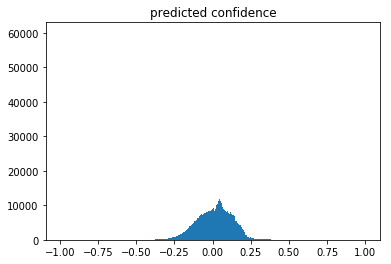

In [11]:
# distribution of confidence that will be used as submission
model.load_weights('model.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 -1
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("predicted confidence")
plt.show()

In [12]:
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.6242531019010438


# Prediction

In [13]:
days = env.get_prediction_days()

In [14]:
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
predicted_confidences = np.array([])
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    print(n_days,end=' ')
    
    t = time.time()

    market_obs_df['assetCode_encoded'] = market_obs_df[cat].astype(str).apply(lambda x: encode(encoders[i], x))

    market_obs_df[num_cols] = market_obs_df[num_cols].fillna(0)
    market_obs_df[num_cols] = scaler.transform(market_obs_df[num_cols])
    X_num_test = market_obs_df[num_cols].values
    X_test = {'num':X_num_test}
    X_test['assetCode'] = market_obs_df['assetCode_encoded'].values
    
    prep_time += time.time() - t
    
    t = time.time()
    market_prediction = model.predict(X_test)[:,0]*2 -1
    predicted_confidences = np.concatenate((predicted_confidences, market_prediction))
    prediction_time += time.time() -t
    
    t = time.time()
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':market_prediction})
    # insert predictions to template
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t

env.write_submission_file()
total = prep_time + prediction_time + packaging_time
print(f'Preparing Data: {prep_time:.2f}s')
print(f'Making Predictions: {prediction_time:.2f}s')
print(f'Packing: {packaging_time:.2f}s')
print(f'Total: {total:.2f}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

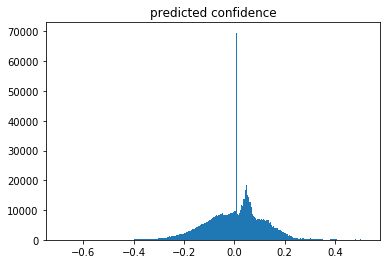

In [15]:
# distribution of confidence as a sanity check: they should be distributed as above
plt.hist(predicted_confidences, bins='auto')
plt.title("predicted confidence")
plt.show()